# 03 | Model Refinement

**Objective:**  
Load and validate previously trained ensemble models on the held-out test set, perform deeper diagnostics (error analysis, threshold tuning), interpret predictions using SHAP, and finalize model selection for deployment.

**Approach:**  
- Load trained ensemble models (Random Forest, XGBoost, LightGBM) and the engineered test set.
- Generate predictions and evaluate model performance on the holdout test set using ROC-AUC, PR-AUC, F1 score, and confusion matrix.
- Compare test set performance against cross-validation scores to assess generalisation and overfitting.
- Conduct error analysis to investigate common characteristics of false positives and false negatives.
- Explore threshold tuning and interpretability using SHAP or other post-hoc techniques.
- Conclude with final model selection based on performance stability and business relevance.

In [177]:
import os
import json
import joblib
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

import shap

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

## Load Engineered Dataset  
We’ll pull from our `credit_risk_engineered` table in the SQLite DB.

In [178]:
conn = sqlite3.connect("../data/loanvet.db")
df = pd.read_sql_query("SELECT * FROM credit_risk_engineered", conn)
conn.close()
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_missing_flag,NumberOfDependents_missing_flag,TotalDelinquencies,RevolvingUtilizationOfUnsecuredLines_log,MonthlyIncome_log,DebtRatio_log,NumberOfTime30-59DaysPastDueNotWorse_log,NumberOfTimes90DaysLate_log,NumberOfTime60-89DaysPastDueNotWorse_log,TotalDelinquencies_log,HighUtilizationFlag,IncomePerCreditLine,AgeGroup_MidAge,AgeGroup_Senior,DependentsGroup_Small,DependentsGroup_Large,Util_x_Late,IncomePerDependent,CreditLines_x_Delinquencies
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,0,0,2,0.568789,9.118335,0.589442,1.098612,0.000000,0.0,1.098612,0,651.428571,1,0,1,0,0.000000,3040.0,26
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0,0,0.671490,7.863651,0.115002,0.000000,0.000000,0.0,0.000000,1,520.000000,1,0,1,0,0.000000,1300.0,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0,0,2,0.505721,8.020599,0.081684,0.693147,0.693147,0.0,1.098612,0,1014.000000,1,0,0,0,0.350539,3042.0,4
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0,0,0.210107,8.101981,0.035415,0.000000,0.000000,0.0,0.000000,0,550.000000,1,0,0,0,0.000000,3300.0,0
4,0,0.907239,49,1,0.024926,50000.0,7,0,1,0,0.0,0,0,1,0.645657,10.819798,0.024620,0.693147,0.000000,0.0,0.693147,1,6250.000000,1,0,0,0,0.000000,50000.0,7


## Drop Redundant Columns

In [179]:
drop_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse",
    'NumberOfTime30-59DaysPastDueNotWorse_log',
    'NumberOfTimes90DaysLate_log',
    'NumberOfTime60-89DaysPastDueNotWorse_log',
    "TotalDelinquencies",
    "MonthlyIncome"
]
df = df.drop(columns=drop_cols, errors="ignore")

## Load Models, Test Data & Metadeta

In [180]:
model_dir = "../models/advanced"
model_paths = {
    "random_forest": os.path.join(model_dir, "random_forest.pkl"),
    "xgboost": os.path.join(model_dir, "xgboost.pkl"),
    "lightgbm": os.path.join(model_dir, "lightgbm.pkl")
}
feature_list_path = os.path.join(model_dir, "feature_list.json")
cv_metrics_path = os.path.join(model_dir, "cv_metrics.json")

rf = joblib.load(model_paths["random_forest"])
xgb = joblib.load(model_paths["xgboost"])
lgbm = joblib.load(model_paths["lightgbm"])

with open(feature_list_path, "r") as f:
    feature_list = json.load(f)

with open(cv_metrics_path, "r") as f:
    cv_metrics = json.load(f)

X = df[feature_list]
y = df["SeriousDlqin2yrs"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (119512, 19), Test size: (29879, 19)


## Evaluate on Holdout Test Set

To ensure consistent evaluation after model loading, we test each trained ensemble model (Random Forest, XGBoost, LightGBM) on the same holdout set used previously. This confirms that model serialisation was successful and sets up downstream diagnostics like threshold tuning and SHAP analysis.

We report:
- ROC-AUC: ranking quality of predicted probabilities
- PR-AUC: precision-recall tradeoff, especially important for imbalanced classification
- F1 Score: harmonic mean of precision and recall
- Confusion Matrix: visual breakdown of prediction outcomes

In [181]:
def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    try:
        y_probs = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        print(f"{name} does not support predict_proba, using decision_function instead.")
        y_scores = model.decision_function(X_test)
        y_probs = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())  # min-max scale

    y_pred = (y_probs >= threshold).astype(int)

    roc_auc = roc_auc_score(y_test, y_probs)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Evaluation:")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "f1": f1,
        "confusion_matrix": cm.tolist(),
        "y_pred": y_pred,
        "y_probs": y_probs
    }

test_results = {}
test_results["Random Forest"] = evaluate_model("Random Forest", rf, X_test, y_test)
test_results["XGBoost"] = evaluate_model("XGBoost", xgb, X_test, y_test)
test_results["LightGBM"] = evaluate_model("LightGBM", lgbm, X_test, y_test)


Random Forest Evaluation:
ROC-AUC: 0.8362
PR-AUC:  0.3549
F1 Score: 0.2635
Confusion Matrix:
[[27599   278]
 [ 1656   346]]

XGBoost Evaluation:
ROC-AUC: 0.8637
PR-AUC:  0.4029
F1 Score: 0.2826
Confusion Matrix:
[[27618   259]
 [ 1630   372]]

LightGBM Evaluation:
ROC-AUC: 0.8633
PR-AUC:  0.3986
F1 Score: 0.3452
Confusion Matrix:
[[22462  5415]
 [  455  1547]]


## Hyperparameter Tuning

We perform hyperparameter tuning using `GridSearchCV` with 5-fold stratified cross-validation. ROC-AUC is used as the primary scoring metric to guide parameter selection, as it is threshold-independent and robust for imbalanced classification problems.

This step aims to extract more predictive power from each model before conducting threshold optimisation.

In [ ]:
# Define parameter grids
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2],
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [1.0],
}

lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1],
    'num_leaves': [31],
}

def tune_model(model, param_grid, model_name):
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(model, param_grid, scoring='roc_auc',
                        cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(f"Best ROC-AUC: {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")
    return grid.best_estimator_

# Tune models
rf_tuned = tune_model(RandomForestClassifier(class_weight='balanced', random_state=42),
                      rf_param_grid, "Random Forest")

xgb_tuned = tune_model(XGBClassifier(eval_metric='logloss', random_state=42),
                       xgb_param_grid, "XGBoost")

lgbm_tuned = tune_model(LGBMClassifier(class_weight='balanced', random_state=42),
                        lgbm_param_grid, "LightGBM")

save_dir = '../models/refinement'
os.makedirs(save_dir, exist_ok=True)

joblib.dump(rf_tuned, os.path.join(save_dir, 'rf_tuned.pkl'))
joblib.dump(xgb_tuned, os.path.join(save_dir, 'xgb_tuned.pkl'))
joblib.dump(lgbm_tuned, os.path.join(save_dir, 'lgbm_tuned.pkl'))

Tuning Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best ROC-AUC: 0.8438
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Tuning XGBoost...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best ROC-AUC: 0.8651
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Tuning LightGBM...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 8007, number of negative: 111505
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 119512, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -

['models/refinement/tuned/lgbm_tuned.joblib']

### Grid Search Hyperparameter Tuning Results

**Random Forest:**  
- **Best ROC-AUC:** 0.8438  
- **Best Parameters:**  
  - `n_estimators`: 200  
  - `max_depth`: 20  
  - `min_samples_split`: 2  

**XGBoost:**  
- **Best ROC-AUC:** 0.8651  
- **Best Parameters:**  
  - `learning_rate`: 0.1  
  - `max_depth`: 3  
  - `n_estimators`: 200  
  - `subsample`: 1.0  

**LightGBM:**  
- **Best ROC-AUC:** 0.8633  
- **Best Parameters:**  
  - `learning_rate`: 0.1  
  - `n_estimators`: 100  
  - `num_leaves`: 31  

These results indicate that tuning led to improved model configurations, with XGBoost achieving the highest ROC-AUC.

After tuning, the best model is saved to disk for future evaluation and deployment.  

We then reload the tuned models to confirm persistence and evaluate their performance on the holdout test set.

To gain further insights into their classification ability, we will also plot the ROC and Precision-Recall curves, which visualise the trade-offs between true positive rates, false positive rates, precision, and recall across different classification thresholds.

In [ ]:
rf_tuned = joblib.load('../models/refinement/rf_tuned.joblib')
xgb_tuned = joblib.load('../models/refinement/xgb_tuned.joblib')
lgbm_tuned = joblib.load('../models/refinement/lgbm_tuned.joblib')

test_results_tuned = {}
test_results_tuned["Random Forest"] = evaluate_model("Random Forest (Tuned)", rf_tuned, X_test, y_test)
test_results_tuned["XGBoost"] = evaluate_model("XGBoost (Tuned)", xgb_tuned, X_test, y_test)
test_results_tuned["LightGBM"] = evaluate_model("LightGBM (Tuned)", lgbm_tuned, X_test, y_test)


Random Forest (Tuned) Evaluation:
ROC-AUC: 0.8434
PR-AUC:  0.3437
F1 Score: 0.3922
Confusion Matrix:
[[27022   855]
 [ 1305   697]]

XGBoost (Tuned) Evaluation:
ROC-AUC: 0.8643
PR-AUC:  0.4038
F1 Score: 0.2893
Confusion Matrix:
[[27614   263]
 [ 1619   383]]

LightGBM (Tuned) Evaluation:
ROC-AUC: 0.8633
PR-AUC:  0.3986
F1 Score: 0.3452
Confusion Matrix:
[[22462  5415]
 [  455  1547]]


## Threshold Optimisation Function

In classification tasks with imbalanced classes, using the default probability threshold of 0.5 often leads to suboptimal precision-recall trade-offs.

We will optimise the classification threshold to maximize F1 score, improving the balance between precision and recall for imbalanced credit risk predictions.

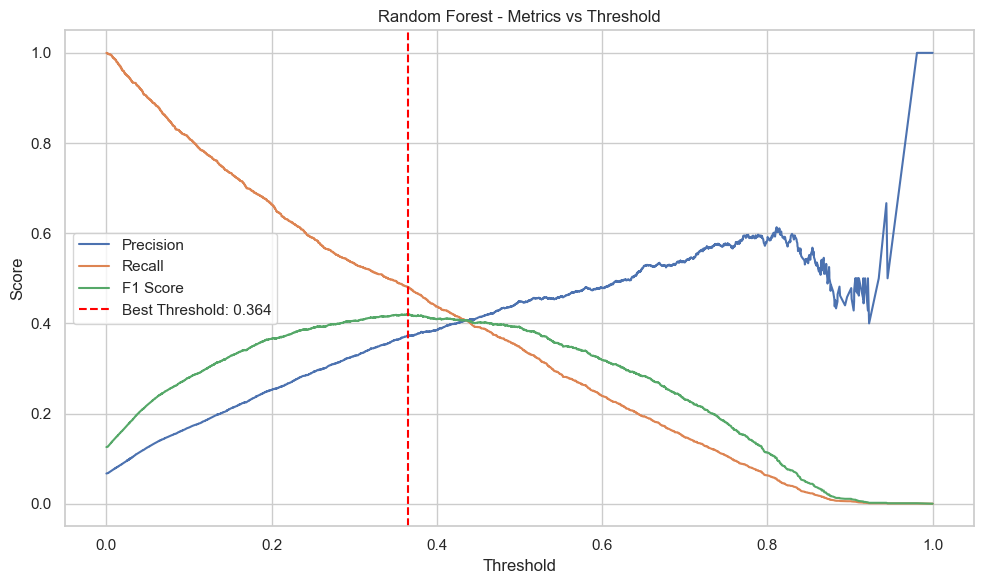

Random Forest Best Threshold: 0.3644
F1: 0.4204, Precision: 0.3731, Recall: 0.4815


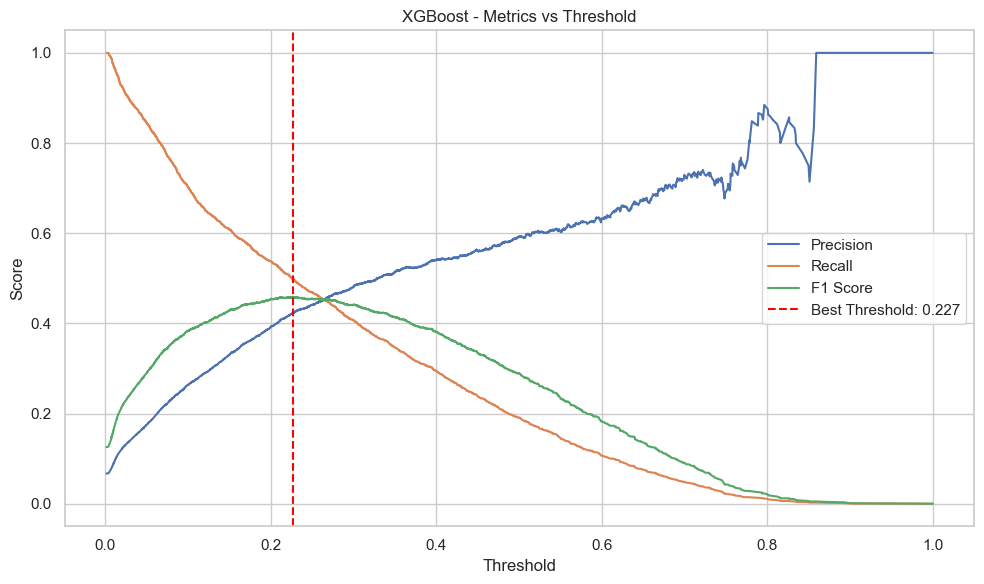

XGBoost Best Threshold: 0.2268
F1: 0.4589, Precision: 0.4244, Recall: 0.4995


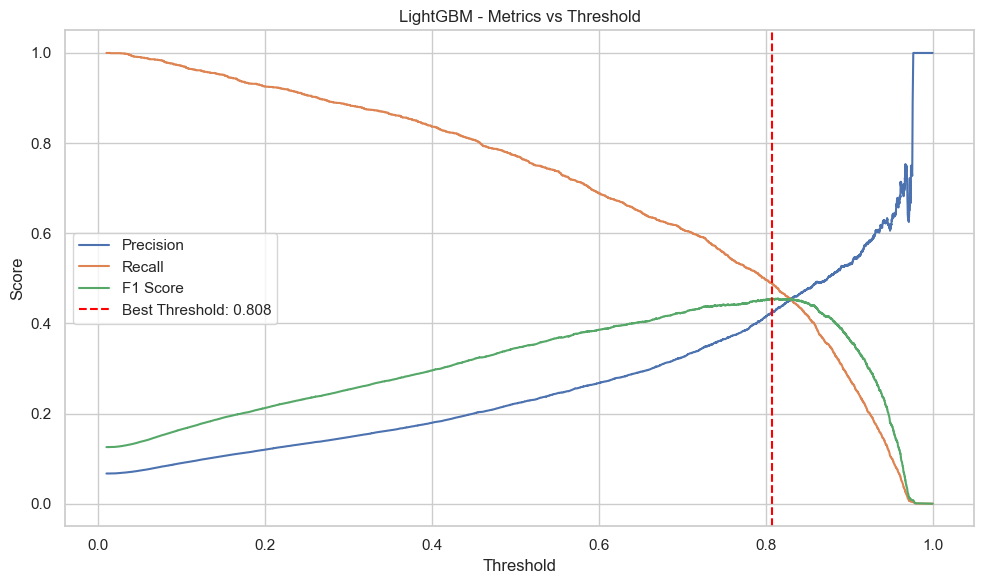

LightGBM Best Threshold: 0.8077
F1: 0.4552, Precision: 0.4258, Recall: 0.4890


In [183]:
def find_best_threshold(y_true, y_probs, metric='f1'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    thresholds = np.append(thresholds, 1.0)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    if metric == 'f1':
        best_idx = np.argmax(f1_scores)
    elif metric == 'recall@70_precision':
        best_idx = next((i for i, p in enumerate(precision) if p >= 0.7), -1)
        if best_idx == -1:
            print("No threshold achieves 70% precision.")
            return None
    else:
        raise ValueError("Unsupported metric.")

    return {
        'best_threshold': thresholds[best_idx],
        'f1': f1_scores[best_idx],
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'thresholds': thresholds,
        'f1_scores': f1_scores,
        'precision_curve': precision,
        'recall_curve': recall
    }

def plot_threshold_metrics(y_true, y_probs, model_name):
    result = find_best_threshold(y_true, y_probs)
    thresholds = result['thresholds']
    f1_scores = result['f1_scores']
    precision = result['precision_curve']
    recall = result['recall_curve']

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision, label="Precision")
    plt.plot(thresholds, recall, label="Recall")
    plt.plot(thresholds, f1_scores, label="F1 Score")
    plt.axvline(result['best_threshold'], linestyle='--', color='red', label=f"Best Threshold: {result['best_threshold']:.3f}")
    plt.title(f"{model_name} - Metrics vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{model_name} Best Threshold: {result['best_threshold']:.4f}")
    print(f"F1: {result['f1']:.4f}, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}")

    return result

rf_thresh_result = plot_threshold_metrics(y_test, test_results_tuned["Random Forest"]["y_probs"], "Random Forest")
xgb_thresh_result = plot_threshold_metrics(y_test, test_results_tuned["XGBoost"]["y_probs"], "XGBoost")
lgb_thresh_result = plot_threshold_metrics(y_test, test_results_tuned["LightGBM"]["y_probs"], "LightGBM")


### Observations from Threshold Tuning

- **XGBoost** achieves the highest F1 score (0.4589) at a low threshold (0.2268), balancing precision (0.4244) and recall (0.4995) moderately well.
- **LightGBM** shows a similar F1 score (0.4552) at a much higher threshold (0.8077), indicating its probability outputs are less calibrated and require a stricter cutoff. Precision is 0.4258 and recall is 0.4890.
- **Random Forest** performs slightly worse (F1: 0.4204) with lower precision (0.3731) but comparable recall (0.4815), using a moderate threshold of 0.3644.
- Overall, lowering thresholds below the default 0.5 improves recall and F1, underscoring the importance of threshold tuning in imbalanced classification.
- However, precision and recall remain moderate, reflecting the inherent difficulty of predicting minority class defaults in this dataset.

In [184]:
optimal_thresholds = {
    "Random Forest": 0.3644,
    "XGBoost": 0.2268,
    "LightGBM": 0.8077
}

for name, model in [("Random Forest", rf_tuned), ("XGBoost", xgb_tuned), ("LightGBM", lgbm_tuned)]:
    threshold = optimal_thresholds[name]
    print(f"\n{name} Evaluation at Optimal Threshold ({threshold:.4f}):")
    _ = evaluate_model(name, model, X_test, y_test, threshold=threshold)


Random Forest Evaluation at Optimal Threshold (0.3644):

Random Forest Evaluation:
ROC-AUC: 0.8434
PR-AUC:  0.3437
F1 Score: 0.4204
Confusion Matrix:
[[26257  1620]
 [ 1038   964]]

XGBoost Evaluation at Optimal Threshold (0.2268):

XGBoost Evaluation:
ROC-AUC: 0.8643
PR-AUC:  0.4038
F1 Score: 0.4589
Confusion Matrix:
[[26521  1356]
 [ 1002  1000]]

LightGBM Evaluation at Optimal Threshold (0.8077):

LightGBM Evaluation:
ROC-AUC: 0.8633
PR-AUC:  0.3986
F1 Score: 0.4552
Confusion Matrix:
[[26557  1320]
 [ 1023   979]]


### Improvement Observation after Threshold Tuning

By applying the optimal classification thresholds for each model, we observed significant improvements in key binary classification metrics, particularly the F1 score.

- The **Random Forest** model's F1 score improved from 0.2635 to **0.4204** (ROC-AUC: 0.8434, PR-AUC: 0.3437).
- The **XGBoost** model's F1 score increased from 0.2826 to **0.4589** (ROC-AUC: 0.8643, PR-AUC: 0.4038).
- The **LightGBM** model's F1 score rose from 0.3452 to **0.4552** (ROC-AUC: 0.8633, PR-AUC: 0.3986).

This improvement demonstrates that selecting an appropriate decision threshold tailored to the model’s probability outputs can substantially enhance the balance between precision and recall, leading to more effective classification performance.

Notably, the ROC-AUC and PR-AUC scores remain consistent since these metrics evaluate model ranking ability across all thresholds, but the optimal threshold tuning enables better practical decision-making for classification.

## Error Analysis: Understanding False Positives and False Negatives

Beyond aggregate performance metrics, it is critical to understand *which* observations the model misclassifies — especially in the context of credit risk, where the cost of false negatives (approving risky borrowers) is significantly higher than false positives (denying safe ones).

We focus our analysis on the best-performing model (XGBoost) using its optimal threshold of 0.2268.

For each prediction outcome:
- **True Positive (TP)**: Correctly predicted default
- **True Negative (TN)**: Correctly predicted non-default
- **False Positive (FP)**: Predicted default but actually safe
- **False Negative (FN)**: Predicted safe but actually defaulted ← most costly

By examining the feature distributions across these error types, we aim to identify patterns that could inform better thresholding, feature design, or risk policy alignment.

Error Type Counts:
 ErrorType
TN    26521
FP     1356
FN     1002
TP     1000
Name: count, dtype: int64
Top 5 XGBoost features for error analysis:
 ['TotalDelinquencies_log', 'RevolvingUtilizationOfUnsecuredLines_log', 'Util_x_Late', 'NumberRealEstateLoansOrLines', 'age']


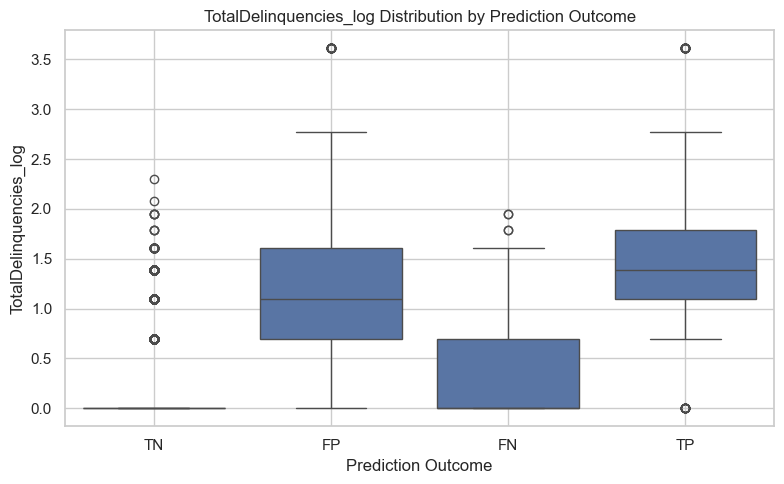

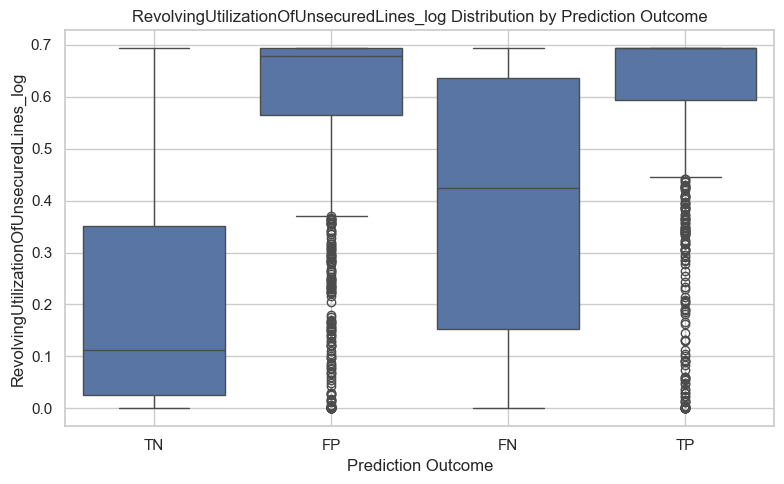

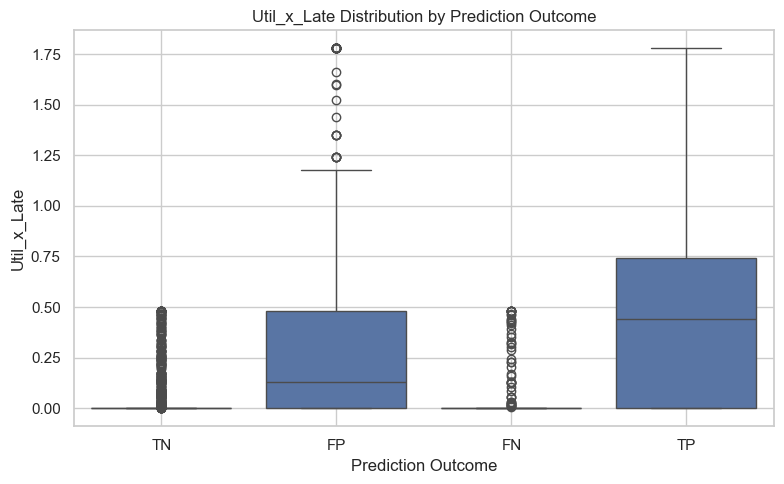

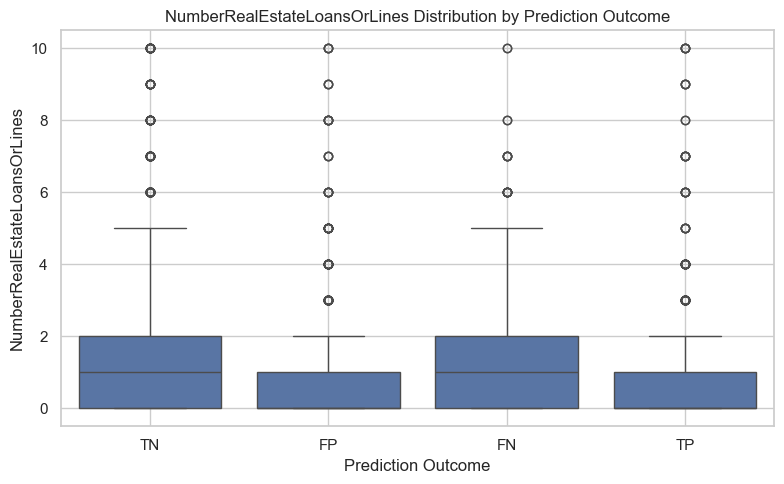

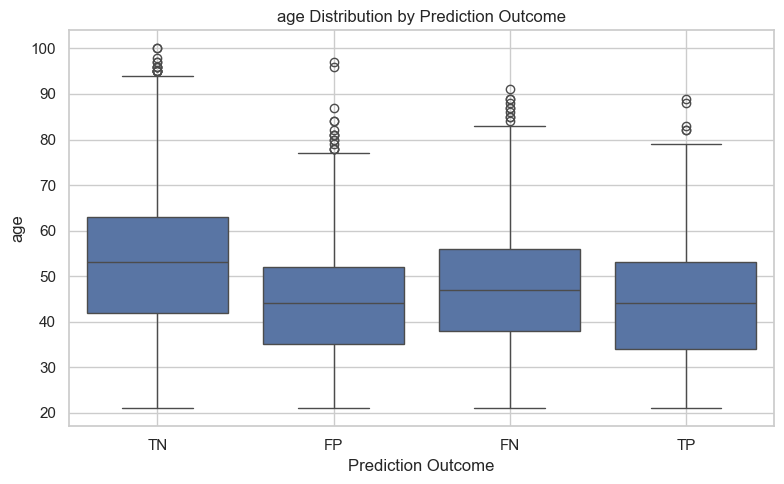

In [185]:
# Step 1: Get predictions using optimal threshold for XGBoost
threshold = optimal_thresholds["XGBoost"]
y_probs = test_results_tuned["XGBoost"]["y_probs"]
y_pred = (y_probs >= threshold).astype(int)

# Step 2: Create DataFrame with predictions and actuals
analysis_df = X_test.copy()
analysis_df["Actual"] = y_test.values
analysis_df["Predicted"] = y_pred
analysis_df["Probability"] = y_probs

# Step 3: Classify each row by prediction outcome
def get_error_type(row):
    if row["Actual"] == 1 and row["Predicted"] == 1:
        return "TP"
    elif row["Actual"] == 0 and row["Predicted"] == 0:
        return "TN"
    elif row["Actual"] == 0 and row["Predicted"] == 1:
        return "FP"
    else:
        return "FN"

analysis_df["ErrorType"] = analysis_df.apply(get_error_type, axis=1)

# Step 4: Show summary counts
error_counts = analysis_df["ErrorType"].value_counts()
print("Error Type Counts:\n", error_counts)

# Step 5: Identify top 5 most important features used by XGBoost
importances = pd.Series(xgb_tuned.feature_importances_, index=X_test.columns)
top_features = importances.sort_values(ascending=False).head(5).index.tolist()
print("Top 5 XGBoost features for error analysis:\n", top_features)

# Step 6: Visualize feature distributions across prediction outcomes
for feature in top_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="ErrorType", y=feature, data=analysis_df,
                order=["TN", "FP", "FN", "TP"])
    plt.title(f"{feature} Distribution by Prediction Outcome")
    plt.xlabel("Prediction Outcome")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Error Analysis

#### Top 5 XGBoost Features Used for Error Analysis

These features were selected based on XGBoost's built-in feature importance scores (via `.feature_importances_`), focusing on variables with high predictive contribution and business interpretability.

1. `TotalDelinquencies_log`
2. `RevolvingUtilizationOfUnsecuredLines_log`
3. `Util_x_Late`
4. `NumberRealEstateLoansOrLines`
5. `age`
6. `AgeGroup_MidAge`

---

#### Box Plot Observations Across Error Types

The following summarises how each key feature varies across the four error groups (`TN`, `FP`, `FN`, `TP`):

- `TotalDelinquencies_log` 
  - TN and FN medians are near **0**, suggesting low delinquency history for actual non-defaulters and missed defaulters.  
  - FP and TP medians are **>1**, indicating that the model is correctly associating high delinquency with defaults, but may be over-sensitive in some cases (FPs).

- `RevolvingUtilizationOfUnsecuredLines_log`
  - TP and FP cases tend to have **higher utilization**, reinforcing that high credit utilization correlates with predicted risk.
  - TN cases show **lower utilization**, as expected for non-defaulting individuals.

- `Util_x_Late`
  - TPs show **high interaction** between late payments and utilization.  
  - TNs and FNs have **much lower** interaction scores, indicating the model is using this signal effectively.

- `NumberRealEstateLoansOrLines`* 
  - TN and FN medians are **1**, while FP and TP cases skew toward **0**, suggesting limited real estate credit exposure is sometimes over-penalized by the model.

- `age` 
  - FP and FN cases tend to be **younger**, hinting at model struggles in certain age brackets.
  - TP and TN distributions are more spread but skew slightly older.

---

#### General Takeaway

- The **box plot patterns make intuitive sense**:
  - TPs and FPs are associated with **higher risk signals**, like delinquency and utilization.
  - TNs and FNs tend to show **lower risk profiles**, with occasional misclassifications.
- No contradictions were observed across error splits, suggesting the model is behaving **coherently with respect to its learned decision boundaries**.

This analysis helps validate model decisions and highlights opportunities to improve edge cases (e.g. young users with limited credit history).

## SHAP Interpretability

To interpret and our model's predictions, we use **SHAP (SHapley Additive exPlanations)** to explain how features contribute to predictions.

### Objectives:
- Understand **global feature importance**: Which features most influence the model’s decisions across the test set?
- Analyse **local explanations**: Why did the model predict a high or low risk for a particular applicant?
- Validate if model decisions align with domain knowledge (e.g., high delinquency history → higher default risk).

We will focus on the best-performing model — **XGBoost**, which showed strong F1 and PR-AUC performance after threshold optimisation.

### Global Explanation (SHAP Feature Importance)
To understand the overall behavior of our XGBoost model, we use SHAP (SHapley Additive exPlanations) to measure each feature’s average contribution across the entire test set.

This global interpretability reveals which features were most influential in driving the model’s predictions.

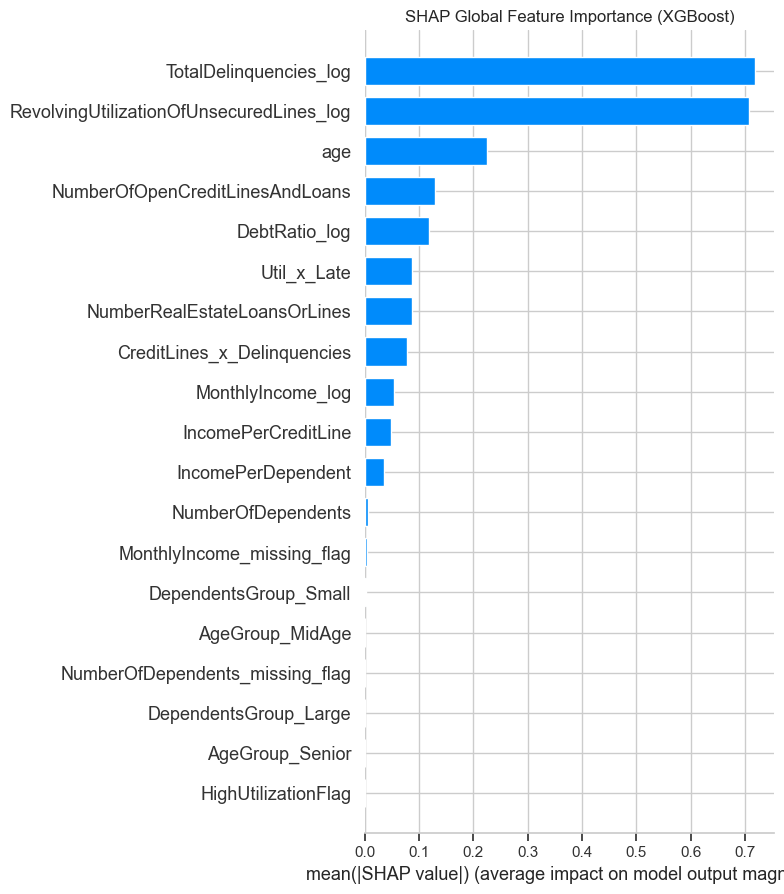

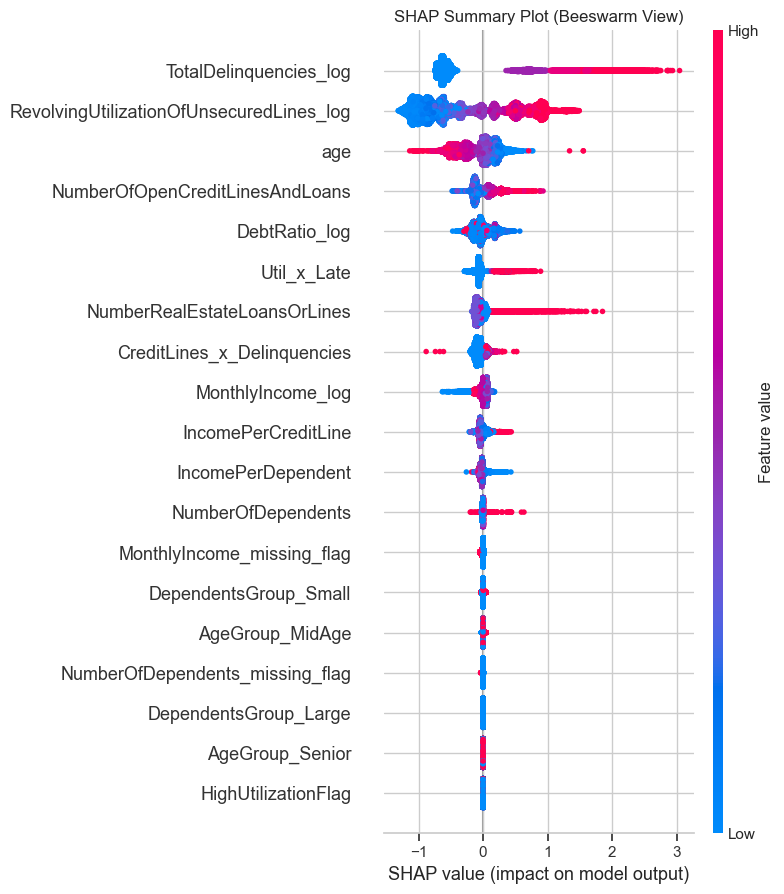

In [186]:
explainer = shap.Explainer(xgb_tuned)
shap_values = explainer(X_test)

# Global Feature Importance (mean absolute SHAP values)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# SHAP Summary Plot (beeswarm): shows feature impact distribution
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot (Beeswarm View)")
plt.tight_layout()
plt.show()

### Interpretation

We interpret the top features identified by SHAP based on their contribution to the model’s predictions (mean absolute SHAP values) and their directional impact shown in the summary plot.

1. `TotalDelinquencies_log`

- Observations with high delinquency history (log-transformed) have large **positive SHAP values**, pushing the model towards predicting **default**.
- Applicants with **zero or low delinquency** show **negative SHAP values**, reducing the predicted risk.
- This confirms that **past delinquency is a strong signal** of credit risk.

2. `RevolvingUtilizationOfUnsecuredLines_log`

- High utilization rates on revolving credit accounts are associated with **positive SHAP values**, indicating **increased risk**.
- Low utilization leads to **negative SHAP values**, reducing the model's prediction of default.
- The model effectively captures **credit overuse as a key risk factor**.

3. `age`

- **Younger individuals** tend to have **positive SHAP values**, contributing to a **higher predicted risk**.
- **Older individuals** are associated with **negative SHAP values**, lowering the predicted risk.
- This suggests the model learns an **inverse correlation between age and default probability**.

4. `NumberOfOpenCreditLinesAndLoans`

- A **higher number of open credit lines and loans** is linked to **positive SHAP values**, implying **higher risk**.
- A **lower count** correlates with **negative SHAP values**, reducing predicted risk.
- The model may treat **overexposure to credit lines** as a warning sign.

5. `DebtRatio_log`

- This feature exhibits a **mixed SHAP value pattern**.
- While some high debt ratios contribute to **higher predicted risk**, others do not.
- This suggests that **debt ratio alone isn't a consistent indicator**, possibly depending on context or interactions with other variables.

6. `Util_x_Late`

- This interaction feature captures **utilization × late payments**.
- **High values** strongly push the prediction towards default (**positive SHAP values**).
- **Low values** reduce predicted risk (**negative SHAP values**).
- The model uses this interaction as a **powerful compound risk signal**.

7. `NumberRealEstateLoansOrLines`

- Individuals with **more real estate loans** tend to have **positive SHAP values**, indicating **higher predicted risk**.
- Having **fewer or no real estate loans** is associated with **lower SHAP values**, reducing predicted default.
- This may reflect the model’s interpretation that **multiple real estate obligations add financial burden**.


## Local Explanation (Instance-Level SHAP)

To explain a specific prediction, we visualise SHAP values for an individual applicant from the test set.  
This tells us **which features pushed the model toward higher or lower predicted risk**.

We'll inspect both a **true positive** (correctly predicted default) and a **false negative** (missed default).

TP index: 34
FN index: 7


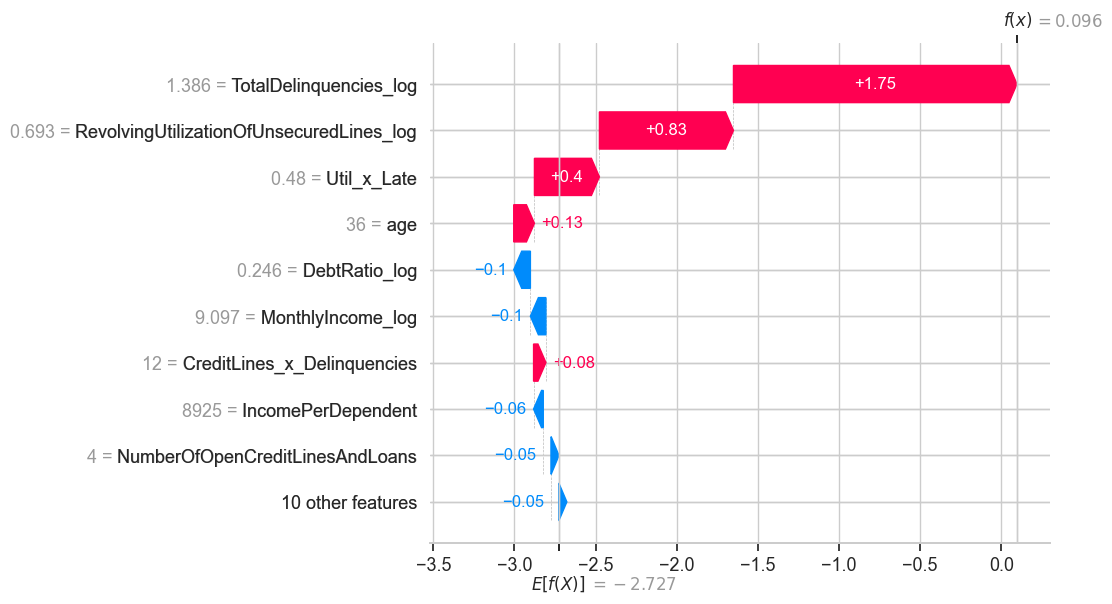

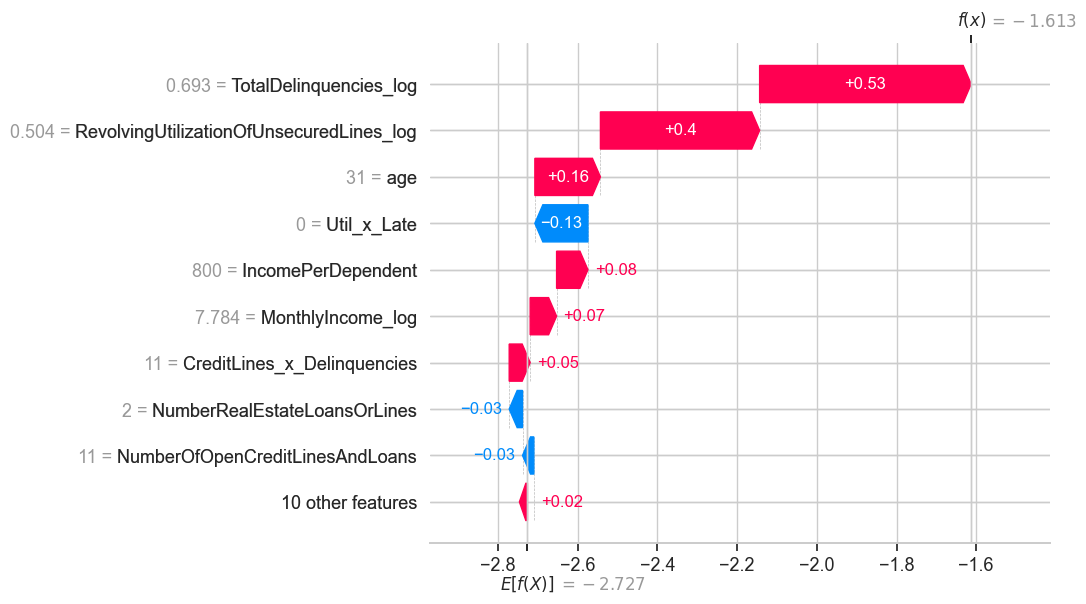

In [187]:
# Get predicted probabilities and labels
y_probs_xgb = test_results_tuned["XGBoost"]["y_probs"]
y_preds_xgb = (y_probs_xgb >= 0.2268).astype(int)

# Find a true positive and false negative
tp_index = np.where((y_test == 1) & (y_preds_xgb == 1))[0][0]
fn_index = np.where((y_test == 1) & (y_preds_xgb == 0))[0][0]

print("TP index:", tp_index)
print("FN index:", fn_index)

# Waterfall plot for a correctly predicted default (TP)
shap.initjs()
shap.plots.waterfall(shap_values[tp_index])

# Waterfall plot for a missed default (FN)
shap.plots.waterfall(shap_values[fn_index])

### Waterfall Plot Interpretation

The TP case shows high delinquency, moderate utilization, and significant credit usage driving the model’s confident prediction of default.

The FN case, despite some risk signals, has lower delinquency and utilization, likely causing the model to underestimate risk, resulting in a missed default.

## Final Model Selection

After extensive evaluation, **XGBoost** was selected as the final model for deployment due to its superior performance on the holdout test set.

**Chosen Threshold:** 0.2268  
**Performance at Optimal Threshold:**  
- F1 Score: 0.4589  
- ROC-AUC: 0.8643  
- PR-AUC: 0.4038  

We now persist the final model, optimal classification threshold, and key metadata for downstream use (e.g., in a Streamlit dashboard or API endpoint).

In [ ]:
final_model_path = "../models/final/xgb_final_model.joblib"
os.makedirs(os.path.dirname(final_model_path), exist_ok=True)

joblib.dump(xgb_tuned, final_model_path)

final_metadata = {
    "model_type": "XGBoost",
    "threshold": 0.2268,
    "roc_auc": 0.8643,
    "pr_auc": 0.4038,
    "f1": 0.4589,
    "features": feature_list
}

with open("../models/final/xgb_final_metadata.json", "w") as f:
    json.dump(final_metadata, f, indent=2)

## Conclusion

The final model captures meaningful credit risk patterns such as:

- High delinquencies and revolving credit utilization increasing default risk

- Younger borrowers and high credit usage predicting higher risk

- Compound indicators like Util_x_Late boosting model signal strength

We’ve exported the model and metadata for downstream use in dashboards or API endpoints. This concludes the model refinement stage of the LoanVet pipeline.